In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
# fix random seed for reproducibility
np.random.seed(7)
# load the dataset
dataframe = read_csv('../data/it-data-4metrics.csv', sep=',')
data = read_csv('LSTM_id2.csv')

In [2]:
dataframe = dataframe.iloc[:,0:4]
# indexNames = dataframe[ dataframe['metric_id'] == dataframe.iloc[95744,0] ].index
# indexNames = dataframe[ dataframe['metric_id'] == dataframe.iloc[117264,0] ].index
# indexNames = dataframe[ dataframe['metric_id'] == data.iloc[70,1] ].index
# indexNames = dataframe[ dataframe['metric_id'] == dataframe.iloc[243333,0] ].index
indexNames = dataframe[ dataframe['metric_id'] == dataframe.iloc[0,0] ].index

dataframe = dataframe.iloc[indexNames].sort_values(by='timestamp', ascending=True).loc[:,['value']]
dataset = dataframe.values
dataset = dataset.astype('float32')

In [3]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [4]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [5]:
# reshape into X=t and Y=t+1
look_back = 30
x_train, y_train = create_dataset(train, look_back)
x_valid, y_valid = create_dataset(test, look_back)

In [6]:
# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_valid = np.reshape(x_valid, (x_valid.shape[0], 1, x_valid.shape[1]))
print(x_valid)
print(y_valid)

[[[0.6253602  0.6599423  0.99999994 ... 0.2939481  0.3314121  0.28818443]]

 [[0.6599423  0.99999994 0.36599424 ... 0.3314121  0.28818443 0.2939481 ]]

 [[0.99999994 0.36599424 0.389049   ... 0.28818443 0.2939481  0.34870318]]

 ...

 [[0.3371758  0.40057635 0.3631124  ... 0.02881844 0.0259366  0.2939481 ]]

 [[0.40057635 0.3631124  0.3573487  ... 0.0259366  0.2939481  0.28818443]]

 [[0.3631124  0.3573487  0.5994236  ... 0.2939481  0.28818443 0.28530258]]]
[0.2939481  0.34870318 0.3054755  0.30259365 0.30835736 0.34005764
 0.32276657 0.32276657 0.3256484  0.36887607 0.40634006 0.3314121
 0.31123918 0.3054755  0.3256484  0.39481267 0.351585   0.30835736
 0.35446686 0.31412104 0.351585   0.32276657 0.32276657 0.30835736
 0.34005764 0.3371758  0.34870318 0.31123918 0.3054755  0.3256484
 0.27089337 0.12680115 0.24207494 0.14697407 0.16426513 0.14697407
 0.17291066 0.10086455 0.20461094 0.17867436 0.13256484 0.15561959
 0.13256484 0.27665704 0.15850145 0.129683   0.14697407 0.21613833
 0.2

In [7]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=100, batch_size=1, verbose=0)

In [8]:
# make predictions
trainPredict = model.predict(x_train)
testPredict = model.predict(x_valid)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_valid = scaler.inverse_transform([y_valid])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_valid[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
testScore = mean_squared_error(y_valid[0], testPredict[:,0], squared=False)
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 3.55 RMSE
Test Score: 3.51 RMSE
Test Score: 3.51 RMSE


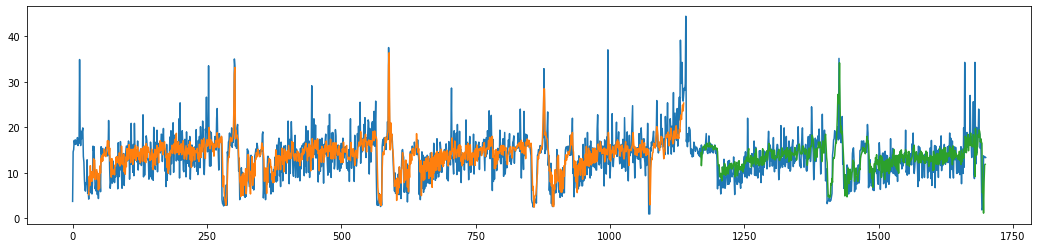

In [9]:
# shift train predictions for plotting
plt.figure(figsize=(18,4))
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()